In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
from dataset_lmdb import *
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
sns.set()

### Reproducibility :)

In [2]:
th.__version__

'1.0.0'

In [3]:
import hashlib
th.manual_seed(int(hashlib.sha1(b'lucent').hexdigest(), 16) % (10 ** 8))
th.cuda.manual_seed_all(int(hashlib.sha1(b'lucent').hexdigest(), 16) % (10 ** 8))
np.random.seed(int(hashlib.sha1(b'lucent').hexdigest(), 16) % (10 ** 8))

### Utility Functions / Modules

In [4]:
def initialize_weights(modules, initializer):
    for m in modules:
        if isinstance(m, nn.Conv1d):
            initializer(tensor=m.weight.data)
            try: m.bias.data.zero_()
            except: pass
        elif isinstance(m, nn.Conv2d):
            initializer(tensor=m.weight.data)
            try: m.bias.data.zero_()
            except: pass
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            try: m.bias.data.zero_()
            except: pass
        elif isinstance(m, nn.BatchNorm1d):
            m.weight.data.fill_(1)
            try: m.bias.data.zero_()
            except: pass
        elif isinstance(m, nn.Linear):
            initializer(tensor=m.weight.data)
            try: m.bias.data.zero_()
            except: pass

In [5]:
class DenseConv1d(nn.Module):
    "Conv-BN-Act-Pool."
    def __init__(self, input_size, output_size, activation, kernel_size, stride, padding, initializer, pool=True):
        super(DenseConv1d, self).__init__()
        self.conv = nn.Conv1d(input_size, output_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm1d(output_size)
        self.act = activation(inplace=True)
        if pool: self.pool = nn.MaxPool1d(kernel_size=kernel_size,
                                          stride=kernel_size)
        else: self.pool = None
        initialize_weights(self.modules(), initializer)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.act(out)
        return self.pool(out) if self.pool else out

In [6]:
class DenseConv2d(nn.Module):
    "Conv-BN-Act-Pool."
    def __init__(self, input_size, output_size, activation, kernel_size, stride, padding, initializer, pool=True):
        super(DenseConv2d, self).__init__()
        self.conv = nn.Conv2d(input_size, output_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(output_size)
        self.act = activation(inplace=True)
        if pool: self.pool = nn.MaxPool2d(kernel_size=kernel_size,
                                          stride=kernel_size)
        else: self.pool = None
        initialize_weights(self.modules(), initializer)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.act(out)
        return self.pool(out) if self.pool else out

### 2D + 1D Convolution Architecture

In [7]:
class SubNet1D(nn.Module):
    num_layers = 5

    def __init__(self, in_dim=128, out_dim=128, activation='ReLU', initialization='kaiming_uniform'):
        super(SubNet1D, self).__init__()
        self.activation = getattr(nn, activation)
        self.initialization = getattr(init, initialization)

        "1D CNN"
        self.conv0 = DenseConv1d(in_dim, 32, activation=self.activation, kernel_size=4, stride=1, padding=2,
                                 initializer=self.initialization)
        self.conv1 = DenseConv1d(160, 32, activation=self.activation, kernel_size=4, stride=1, padding=2,
                                 initializer=self.initialization)
        self.conv2 = DenseConv1d(192, 32, activation=self.activation, kernel_size=4, stride=1, padding=2,
                                 initializer=self.initialization)
        self.conv3 = DenseConv1d(224, 32, activation=self.activation, kernel_size=3, stride=1, padding=1,
                                 initializer=self.initialization)
        self.conv4 = DenseConv1d(256, out_dim, activation=self.activation, kernel_size=1, stride=1, padding=0,
                                 pool=False, initializer=self.initialization)

        initialize_weights(self.modules(), self.initialization)

    def forward(self, x):
        out = x.transpose(1, 2)

        outs = [out]
        pools = [4, 4, 4, 3, 1]
        for i in range(SubNet1D.num_layers):
            out = getattr(self, f'conv{i}')(torch.cat(outs, 1))
            if pools[i] > 1:
                outs = [F.max_pool1d(o, kernel_size=pools[i], stride=pools[i]) for o in outs]
            outs.append(out)

        "Global Pooling"
        mean = F.adaptive_avg_pool1d(out, 1).squeeze(-1)
        return mean

In [8]:
class SubNet2D(nn.Module):
    num_layers = 5

    def __init__(self, in_dim=1, out_dim=128, activation='ReLU', initialization='kaiming_uniform'):
        super(SubNet2D, self).__init__()
        self.activation = getattr(nn, activation)
        self.initialization = getattr(init, initialization)

        "2D CNN"
        self.conv0 = DenseConv2d(1, 32, activation=self.activation, kernel_size=4, stride=1, padding=2,
                                 initializer=self.initialization)
        self.conv1 = DenseConv2d(33, 32, activation=self.activation, kernel_size=4, stride=1, padding=2,
                                 initializer=self.initialization)
        self.conv2 = DenseConv2d(65, 32, activation=self.activation, kernel_size=4, stride=1, padding=2,
                                 initializer=self.initialization)
        self.conv3 = DenseConv2d(97, 32, activation=self.activation, kernel_size=3, stride=1, padding=1,
                                 initializer=self.initialization)
        self.conv4 = DenseConv2d(129, out_dim, activation=self.activation, kernel_size=1, stride=1, padding=0,
                                 pool=False, initializer=self.initialization)

        initialize_weights(self.modules(), self.initialization)

    def forward(self, x):
        out = th.unsqueeze(x.transpose(1, 2), 1)

        outs = [out]
        pools = [4, 4, 4, 3, 1]
        for i in range(SubNet2D.num_layers):
            out = getattr(self, f'conv{i}')(torch.cat(outs, 1))
            if pools[i] > 1:
                outs = [F.max_pool2d(o, kernel_size=pools[i], stride=pools[i]) for o in outs]
            outs.append(out)

        "Global Pooling"
        mean = F.adaptive_avg_pool2d(out, 1).squeeze(-1).squeeze(-1)
        return mean

In [9]:
class MultiScaleCNN(nn.Module):
    def __init__(self, in_dim=128, out_dim=128, activation='ReLU', initialization='kaiming_uniform'):
        super(MultiScaleCNN, self).__init__()
        self.activation = getattr(nn, activation)
        self.initialization = getattr(init, initialization)

        "1D + 2D CNN"
        self.net1 = SubNet1D(in_dim, out_dim, activation, initialization)
        self.net2 = SubNet2D(1, out_dim, activation, initialization)
        self.regression = nn.Linear(out_dim * 2, out_dim, bias=False)

        initialize_weights(self.modules(), self.initialization)

    def forward(self, x):
        a = self.net1(x)
        b = self.net2(x)
        out = self.regression(torch.cat([a, b], 1))
        return out

## Find Good Learning Rate

In [10]:
BATCH_SIZE = 20
WD = 1e-4

def find_lr(model, train_dl, epochs=1, start=1e-2, end=30.0, beta=0.98):
    optimizer = optim.Adam(model.parameters(), lr=start, betas=(0.9,0.99)) # We will use AdamW
    avg_loss, best_loss = 0, float('inf')
    step = (end / start) ** (1/(len(train_dl) * epochs - 1))
    i, lr = 1, start
    lr_losses = []

    for _ in range(epochs):
        for batch in train_dl:
            xs, y = batch['x'], batch['y']
            if len(xs) == 0 or len(xs[0]) == 0:
                if return_outputs: rets.append(np.zeros(y.shape))
                continue
            outputs = Variable(torch.zeros(*y.shape), requires_grad=False).type(torch.cuda.FloatTensor)
            y = Variable(y, requires_grad=False).type(torch.cuda.FloatTensor)
            for x in xs:
                x = Variable(x, requires_grad=False).type(torch.cuda.FloatTensor)
                outs = model(x)
                outputs += outs
            outputs /= len(xs)

            model.zero_grad()
            optimizer.zero_grad()
            loss = F.mse_loss(outputs, y)
            avg_loss = beta * avg_loss + (1-beta) * loss.data.item()
            smoothed_loss = avg_loss / (1 - beta ** i)
            lr_losses.append((lr, smoothed_loss, loss.data.item()))
            if smoothed_loss > 4 * best_loss:
                return lr_losses
            elif smoothed_loss < best_loss:
                best_loss = smoothed_loss
            loss.backward()
            for group in optimizer.param_groups:
                for param in group['params']:
                    param.data = param.data.add(-WD * group['lr'], param.data)
            optimizer.step()
            lr *= step
            optimizer.param_groups[0]['lr'] = lr
            i += 1
    return lr_losses

In [11]:
model = MultiScaleCNN(activation='RReLU', initialization='kaiming_uniform', out_dim=100).cuda().train()
data = get_msd_songs(window_size=600, batch_size=20)
lr_loss = find_lr(model, data.train)

/home/lucent/.pyenv/versions/3.6.4/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  after removing the cwd from sys.path.
/home/lucent/.pyenv/versions/3.6.4/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  
/home/lucent/.pyenv/versions/3.6.4/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


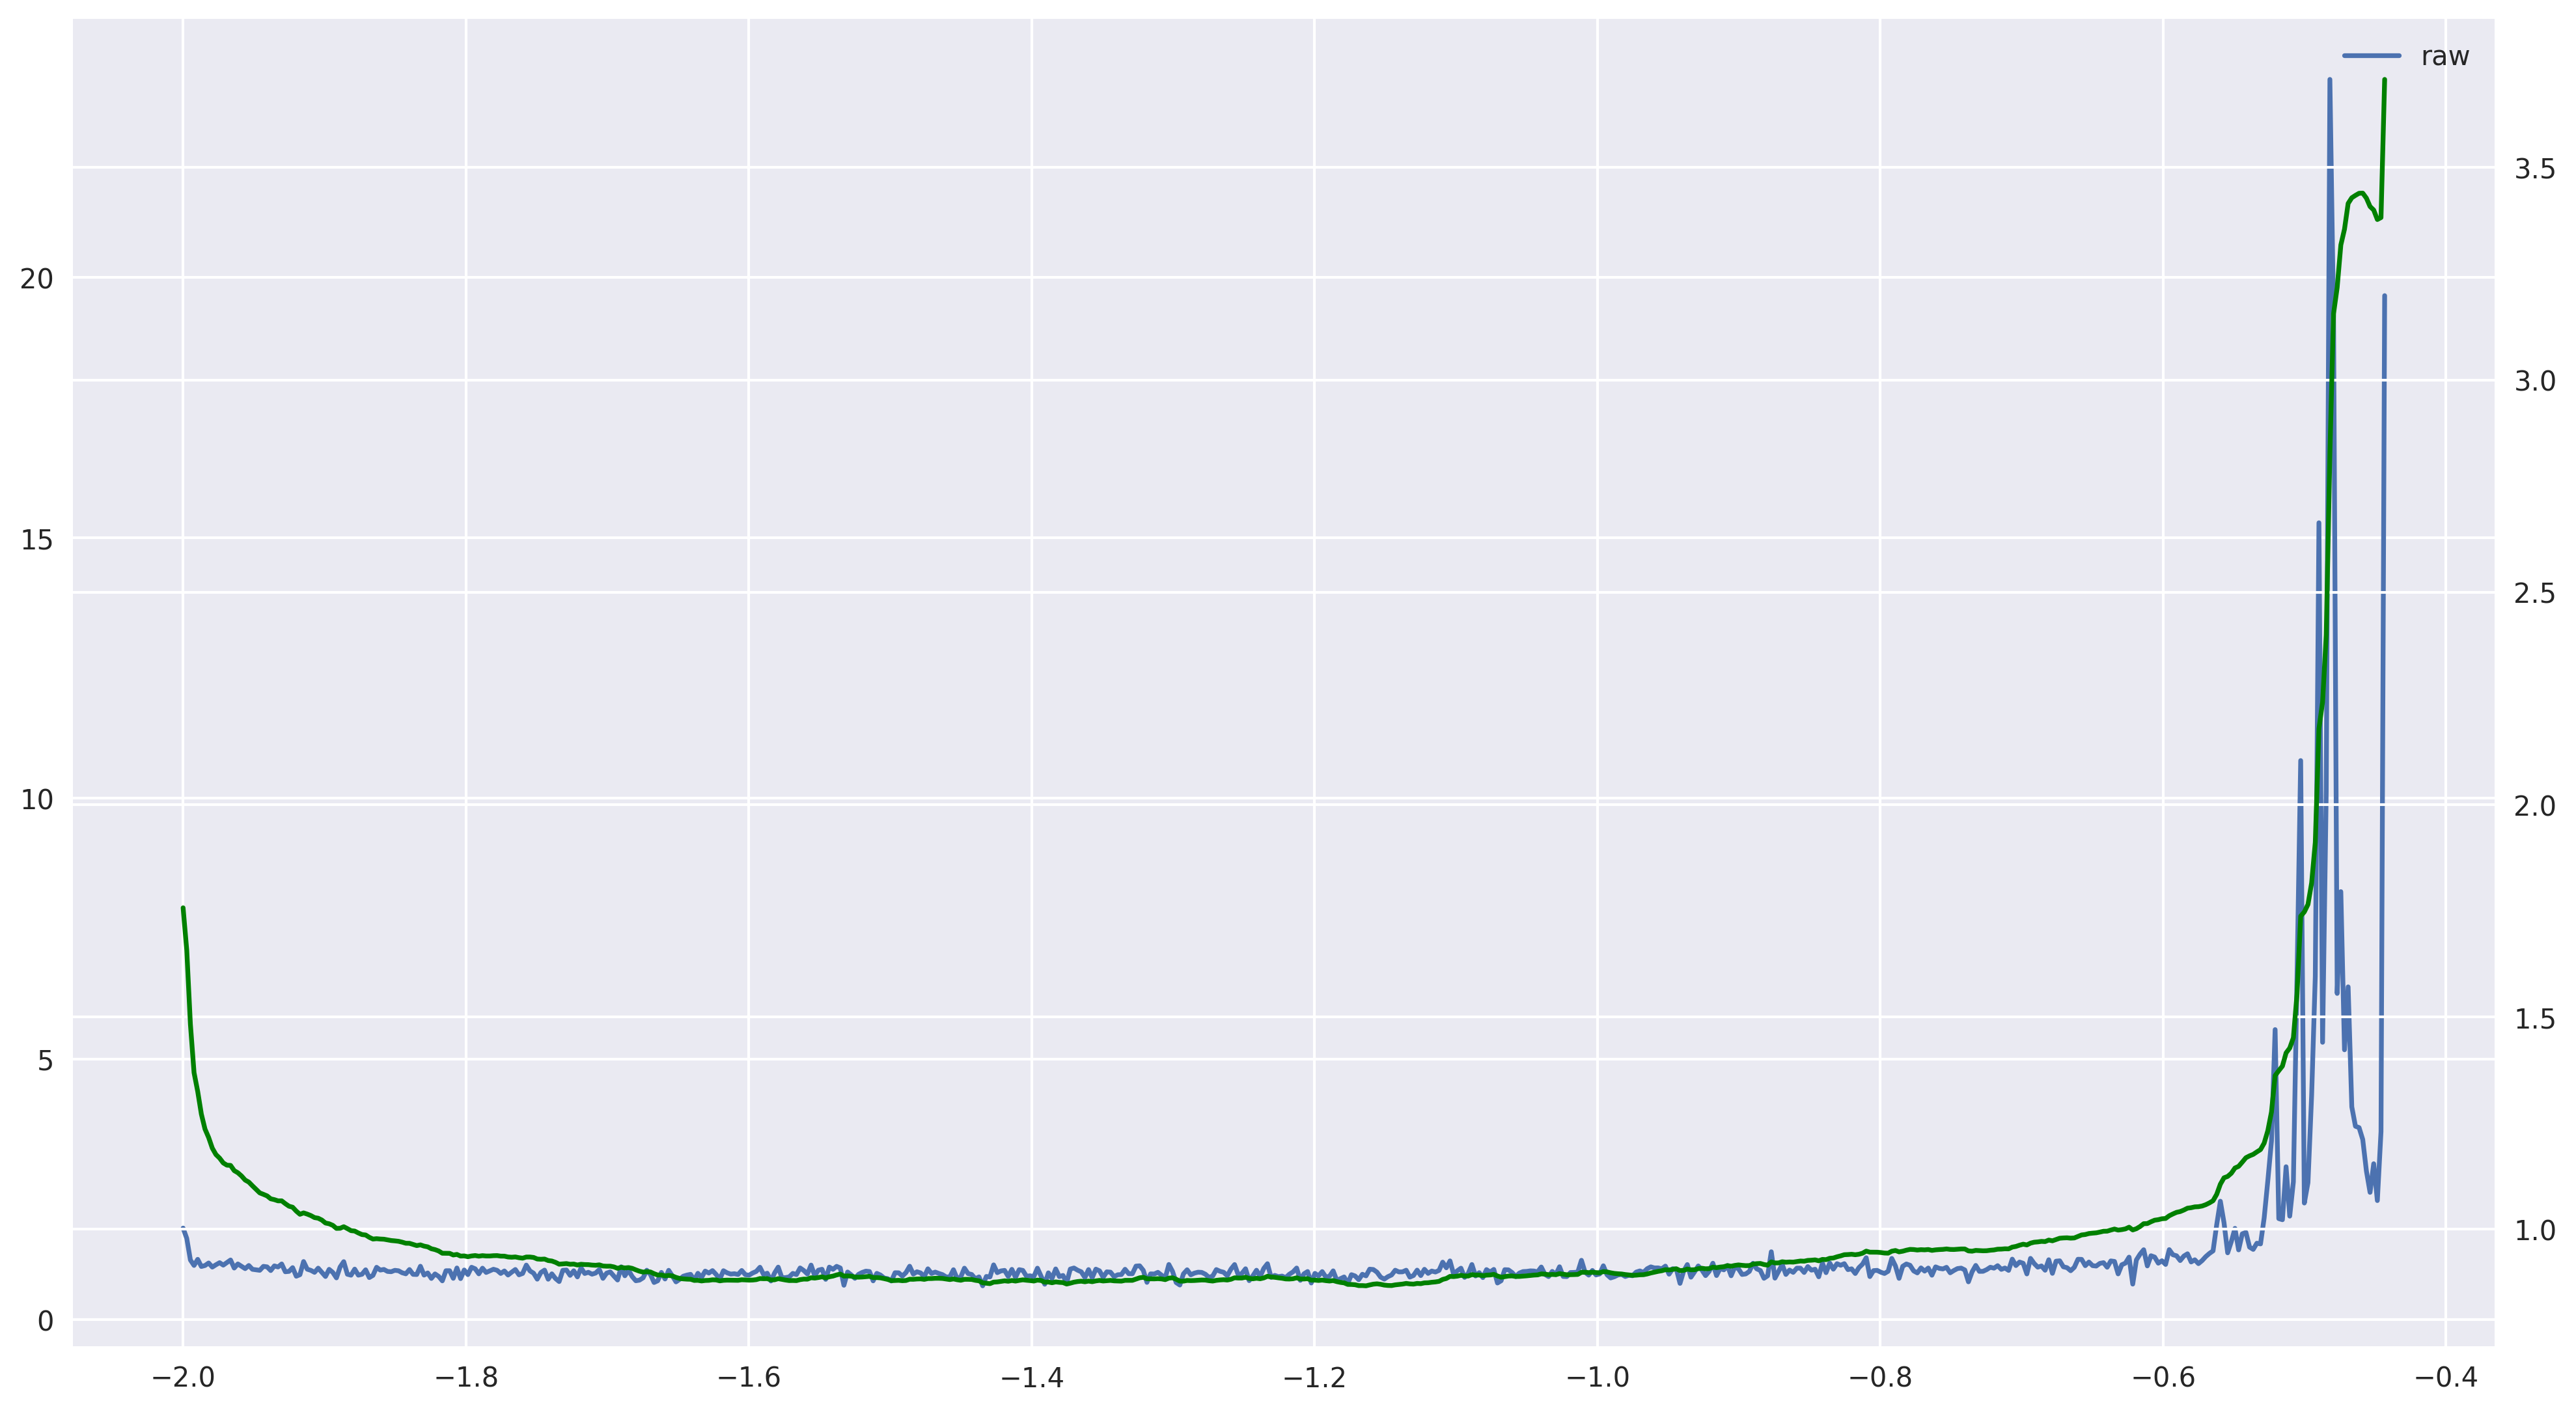

In [12]:
import math

fig, ax = plt.subplots(figsize=(16, 9), dpi=300)
xs, ys = ([math.log10(p[0]) for p in lr_loss], [p[-1] for p in lr_loss])
ax.plot(xs, ys)

ax2 = ax.twinx()
xs, ys = ([math.log10(p[0]) for p in lr_loss], [p[1] for p in lr_loss])
ax2.plot(xs, ys, color='green')

ax.legend(['raw', 'smoothed'], ncol=1, loc='upper right')
plt.show()

### Train

In [13]:
def eval(model, dataset, return_outputs=False):
    torch.cuda.empty_cache()
    model = model.eval()
    avg_loss, rets = [], []
    criterion = torch.nn.MSELoss()
    for batch in dataset:
        xs, y = batch['x'], batch['y']
        if len(xs) == 0 or len(xs[0]) == 0:
            if return_outputs: rets.append(np.zeros(y.shape))
            continue
        outputs = Variable(torch.zeros(*y.shape), requires_grad=False).type(torch.cuda.FloatTensor)
        y = Variable(y, requires_grad=False).type(torch.cuda.FloatTensor)
        for x in xs:
            x = Variable(x, requires_grad=False).type(torch.cuda.FloatTensor)
            outs = model(x)
            outputs += outs
        outputs /= len(xs)
        if return_outputs: rets.append(outputs.cpu().detach().numpy())
        loss = criterion(outputs, y)
        avg_loss.append(loss.data.item())
    torch.cuda.empty_cache()

    if return_outputs:
        rets = np.concatenate(rets, axis=0)
        return np.mean(avg_loss), rets
    return np.mean(avg_loss)

In [ ]:
WD = 1e-6
def train(model, train_dataset, valid_dataset, epochs=10, name='1'):
    def cyclical_lr(min_lr, max_lr, num_steps, p_tails=0.25, eps=0.025):
        peak_step = num_steps * (1 - p_tails) // 2
        print(f'steps: {peak_step}')
        def lr_func(step):
            if step <= peak_step:
                return min_lr + (max_lr - min_lr) * (step / peak_step)
            elif step > 2 * peak_step:
                return min_lr - (step - peak_step * 2) * eps
            else:
                return max(1e-18, max_lr - (max_lr - min_lr) * (step - peak_step) / peak_step)
        return lr_func
    optimizer = optim.Adam(model.parameters(), lr=1.)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, cyclical_lr(0.01, 1, epochs))
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        model = model.train()
        avg_loss = []
        scheduler.step()
        for batch in train_dataset:
            xs, y = batch['x'], batch['y']
            optimizer.zero_grad(); model.zero_grad()
            y = Variable(y).type(torch.cuda.FloatTensor)
            outputs = Variable(torch.zeros(*y.shape)).type(torch.cuda.FloatTensor)
            for x in xs:
                x = Variable(x).type(torch.cuda.FloatTensor)
                outs = model(x)
                outputs += outs
            outputs /= len(xs)
            loss = criterion(outputs, y)
            avg_loss.append(loss.data.item())
            loss.backward()
            for group in optimizer.param_groups:
                for param in group['params']:
                    param.data = param.data.add(-WD * group['lr'], param.data)
            optimizer.step()

        tr_loss = np.mean(avg_loss)
        val_loss = eval(model, valid_dataset)
        print(f'[Epoch {epoch+1:3d}/{epochs}] LR: {optimizer.param_groups[0]['lr']} Train Loss: ' +\
              f'{tr_loss:.4f}, Valid Loss: {val_loss:.4f}.')

    ckpt_name = f'model{name}.bin'
    torch.save(f=ckpt_name, obj=model.state_dict())
    return model

In [15]:
BATCH_SIZE = 20
name = '1'

"Create a model, train the model, and finally test the model."
model = MultiScaleCNN(activation='RReLU', initialization='kaiming_uniform', out_dim=100).cuda().train()
data = get_msd_songs(window_size=600, batch_size=BATCH_SIZE)
model = train(model, data.train, data.valid, epochs=20, name=name)

"Create embeddings for every song, and then save it."
t_data = get_msd_songs_all(window_size=600, batch_size=1)
total_loss, encodings = eval(model, t_data, return_outputs=True)
emb_path = f'./kor_embedding{name}.npy'
np.save(emb_path, encodings)
print(f'Total Loss: {total_loss}, embedding is saved to {emb_path}.')

steps: 9.0


/home/lucent/.pyenv/versions/3.6.4/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  after removing the cwd from sys.path.
/home/lucent/.pyenv/versions/3.6.4/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  
/home/lucent/.pyenv/versions/3.6.4/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


[Epoch   1/20] Train Loss: 0.8576, Valid Loss: 0.8424.
[Epoch   2/20] Train Loss: 0.9426, Valid Loss: 0.9245.
[Epoch   3/20] Train Loss: 8.7527, Valid Loss: 0.9546.
[Epoch   4/20] Train Loss: 0.9716, Valid Loss: 0.9199.
[Epoch   5/20] Train Loss: 1.0892, Valid Loss: 0.8614.
[Epoch   6/20] Train Loss: 0.9038, Valid Loss: 0.9371.
[Epoch   7/20] Train Loss: 1198.9126, Valid Loss: 13.0435.
[Epoch   8/20] Train Loss: 23.5392, Valid Loss: 3.7207.
[Epoch   9/20] Train Loss: 6.2353, Valid Loss: 15.0098.
[Epoch  10/20] Train Loss: 2.7216, Valid Loss: 1.5402.
[Epoch  11/20] Train Loss: 1.6460, Valid Loss: 1.3763.
[Epoch  12/20] Train Loss: 1.1988, Valid Loss: 1.0393.
[Epoch  13/20] Train Loss: 0.9660, Valid Loss: 0.8976.
[Epoch  14/20] Train Loss: 0.8878, Valid Loss: 0.8733.
[Epoch  15/20] Train Loss: 0.8818, Valid Loss: 0.8696.
[Epoch  16/20] Train Loss: 0.8809, Valid Loss: 0.8900.
[Epoch  17/20] Train Loss: 0.8786, Valid Loss: 0.9168.
[Epoch  18/20] Train Loss: 0.8611, Valid Loss: 0.8622.
[Epo

In [17]:
def train2(model, train_dataset, valid_dataset, optimizer, max_epoch, early_stop, scheduler):
    criterion = nn.MSELoss()
    for epoch in range(max_epoch):
        model = model.train()
        avg_loss = []
        for batch in train_dataset:
            xs, y = batch['x'], batch['y']
            optimizer.zero_grad(); model.zero_grad()
            y = Variable(y).type(torch.cuda.FloatTensor)
            outputs = Variable(torch.zeros(*y.shape)).type(torch.cuda.FloatTensor)
            for x in xs:
                x = Variable(x).type(torch.cuda.FloatTensor)
                outs = model(x)
                outputs += outs
            outputs /= len(xs)
            loss = criterion(outputs, y)
            avg_loss.append(loss.data.item())
            loss.backward()
            for group in optimizer.param_groups:
                for param in group['params']:
                    param.data = param.data.add(-WD * group['lr'], param.data)
            optimizer.step()

        tr_loss = np.mean(avg_loss)
        val_loss = eval(model, valid_dataset)
        print(f'[Epoch {epoch+1:3d}/{max_epoch}] Train Loss: ' +\
              f'{tr_loss:.4f}, Valid Loss: {val_loss:.4f}.')

        if scheduler: scheduler.step(val_loss)
        if optimizer.param_groups[0]['lr'] <= early_stop:
            print('Early Stopping!')
            break

        ckpt_name = f'model1.1-{epoch}.bin'
        torch.save(f=ckpt_name, obj=model.state_dict())
    return model

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=10 ** -1.15)
max_epoch, lr, early_stop = 10, 10 ** -1.15, 1e-3
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                      cooldown=0, factor=0.2, patience=3, verbose=True)

data = get_msd_songs(window_size=600, batch_size=BATCH_SIZE)
model = train2(model, data.train, data.valid, optimizer, max_epoch,
               early_stop, scheduler)

[Epoch   1/10] Train Loss: 0.8183, Valid Loss: 0.8485.
[Epoch   2/10] Train Loss: 0.8177, Valid Loss: 0.8380.
[Epoch   3/10] Train Loss: 0.8171, Valid Loss: 0.8187.
[Epoch   4/10] Train Loss: 0.8151, Valid Loss: 0.8178.
[Epoch   5/10] Train Loss: 0.8155, Valid Loss: 0.8491.
[Epoch   6/10] Train Loss: 0.8125, Valid Loss: 0.8353.
[Epoch   7/10] Train Loss: 0.8118, Valid Loss: 0.8811.


In [ ]:
"Create embeddings for every song, and then save it."
t_data = get_msd_songs_all(window_size=600, batch_size=1)
total_loss, encodings = eval(model, t_data, return_outputs=True)
emb_path = f'./kor_embedding1.1.npy'
np.save(emb_path, encodings)
print(f'Total Loss: {total_loss}, embedding is saved to {emb_path}.')

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=10 ** -1.15)
max_epoch, lr, early_stop = 10, 10 ** -1.15, 1e-3
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                      cooldown=0, factor=0.2, patience=3, verbose=True)

data = get_msd_songs(window_size=600, batch_size=BATCH_SIZE)
model = train2(model, data.train, data.valid, optimizer, max_epoch,
               early_stop, scheduler)

In [ ]:
"Create embeddings for every song, and then save it."
t_data = get_msd_songs_all(window_size=600, batch_size=1)
total_loss, encodings = eval(model, t_data, return_outputs=True)
emb_path = f'./kor_embedding1.2.npy'
np.save(emb_path, encodings)
print(f'Total Loss: {total_loss}, embedding is saved to {emb_path}.')

In [ ]:
BATCH_SIZE = 20
name = '2'

"Create a model, train the model, and finally test the model."
model = MultiScaleCNN(activation='RReLU', initialization='kaiming_uniform', out_dim=100).cuda().train()
data = get_msd_songs(window_size=600, batch_size=BATCH_SIZE)
model = train(model, data.train, data.valid, epochs=60, name=name)

"Create embeddings for every song, and then save it."
t_data = get_msd_songs_all(window_size=600, batch_size=1)
total_loss, encodings = eval(model, t_data, return_outputs=True)
emb_path = f'./kor_embedding{name}.npy'
np.save(emb_path, encodings)
print(f'Total Loss: {total_loss}, embedding is saved to {emb_path}.')